In [1]:
#Imports
import pandas as pd
import gensim
from gensim import corpora
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.phrases import Phrases, Phraser
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from tqdm import tqdm
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

# Setup
print("Setting up...")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

🔍 Setting up...


[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [2]:
stop_words = set(stopwords.words('english')).union(STOPWORDS)

lemmatizer = WordNetLemmatizer()

# Domain-Specific Stopwords
custom_stopwords = set([
    'sabrina', 'carpenter', 'even', 'didnt', 'lol', 'yeah', 'get', 'know', 'one', 'also', 'dont',
    'shes', 'got', 'thing', 'song', 'video', 'like', 'people', 'please', 'thanks', 'thank', 'thats'
])

# Load Data
print("Loading data...")
comments_df = pd.read_csv("comments_with_sentiment_updated.csv")
replies_df = pd.read_csv("replies_with_sentiment_updated.csv")

# Clean null/empty entries
comments_df = comments_df[comments_df['cleaned_text'].notnull() & (comments_df['cleaned_text'].str.strip() != '')]
replies_df = replies_df[replies_df['cleaned_text'].notnull() & (replies_df['cleaned_text'].str.strip() != '')]

df = pd.concat([comments_df, replies_df], ignore_index=True)
print(f"Combined dataset shape: {df.shape}")

# Preprocessing with Lemmatization
print("Preprocessing text...")
tqdm.pandas()

def preprocess(text):
    tokens = word_tokenize(str(text).lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words 
              and word not in custom_stopwords and len(word) > 2]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

df['tokens'] = df['cleaned_text'].progress_apply(preprocess)

# Bigrams/Trigrams
print("Creating bigrams and trigrams...")
bigram = Phrases(df['tokens'], min_count=5, threshold=100)
trigram = Phrases(bigram[df['tokens']], threshold=100)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

df['tokens'] = df['tokens'].apply(lambda x: trigram_mod[bigram_mod[x]])

# Dictionary and Corpus
print("Creating dictionary and corpus...")
texts = df['tokens'].tolist()
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=10, no_above=0.5)
print(f"Dictionary size after filtering: {len(dictionary)}")

corpus = [dictionary.doc2bow(text) for text in texts]
print(f"Corpus created with {len(corpus)} documents.")

#TF-IDF Model
print("Applying TF-IDF weighting...")
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

📥 Loading data...
✅ Combined dataset shape: (92668, 12)
🧹 Preprocessing text...


100%|██████████████████████████████████████████████████████████████████████████| 92668/92668 [00:19<00:00, 4708.94it/s]


🔗 Creating bigrams and trigrams...
📚 Creating dictionary and corpus...
📖 Dictionary size after filtering: 4841
✅ Corpus created with 92668 documents.
⚖️ Applying TF-IDF weighting...



🔍 Evaluating: Topics=3, Alpha=symmetric, Eta=symmetric
✅ Coherence: 0.5193 | Topics: 3, Alpha: symmetric, Eta: symmetric

🔍 Evaluating: Topics=4, Alpha=symmetric, Eta=symmetric
✅ Coherence: 0.4430 | Topics: 4, Alpha: symmetric, Eta: symmetric

🔍 Evaluating: Topics=5, Alpha=symmetric, Eta=symmetric
✅ Coherence: 0.4226 | Topics: 5, Alpha: symmetric, Eta: symmetric

🔍 Evaluating: Topics=6, Alpha=symmetric, Eta=symmetric
✅ Coherence: 0.4500 | Topics: 6, Alpha: symmetric, Eta: symmetric

🔍 Evaluating: Topics=3, Alpha=symmetric, Eta=0.1
✅ Coherence: 0.5845 | Topics: 3, Alpha: symmetric, Eta: 0.1

🔍 Evaluating: Topics=4, Alpha=symmetric, Eta=0.1
✅ Coherence: 0.4874 | Topics: 4, Alpha: symmetric, Eta: 0.1

🔍 Evaluating: Topics=5, Alpha=symmetric, Eta=0.1
✅ Coherence: 0.4299 | Topics: 5, Alpha: symmetric, Eta: 0.1

🔍 Evaluating: Topics=6, Alpha=symmetric, Eta=0.1
✅ Coherence: 0.4542 | Topics: 6, Alpha: symmetric, Eta: 0.1

🔍 Evaluating: Topics=3, Alpha=0.1, Eta=symmetric
✅ Coherence: 0.5030 | 

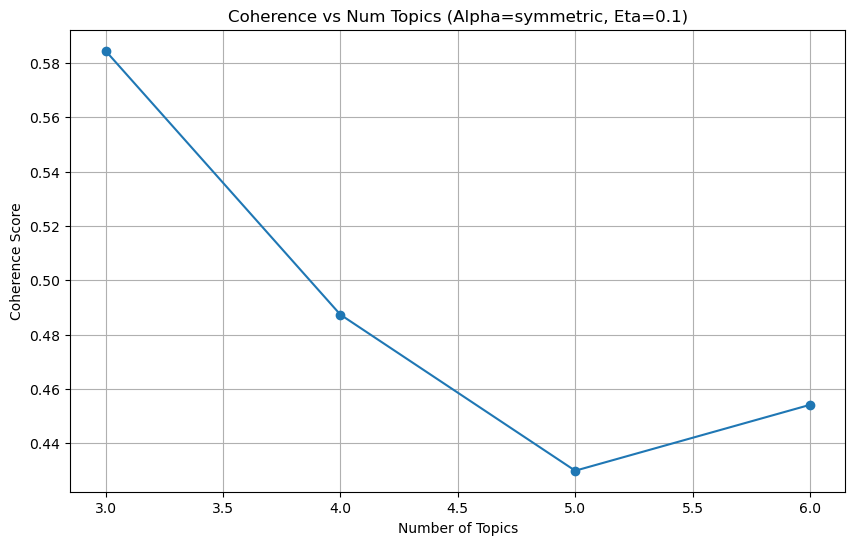


🧠 Training Final LDA Model: Topics=3, Alpha=symmetric, Eta=0.1

🎯 Final Coherence Score: 0.5633


In [31]:
# import gensim
# from gensim.models import CoherenceModel, LdaMulticore
# import matplotlib.pyplot as plt
# import pandas as pd

# # === Coherence Evaluation Function ===
# def evaluate_lda(corpus, dictionary, texts, alpha_vals, eta_vals, topic_range):
#     results = []
#     for alpha in alpha_vals:
#         for eta in eta_vals:
#             for num_topics in topic_range:
#                 print(f"\nEvaluating: Topics={num_topics}, Alpha={alpha}, Eta={eta}")
#                 lda_model = LdaMulticore(
#                     corpus=corpus,
#                     id2word=dictionary,
#                     num_topics=num_topics,
#                     alpha=alpha,
#                     eta=eta,
#                     random_state=42,
#                     passes=15,
#                     iterations=100,
#                     chunksize=100,
#                     workers=4
#                 )
#                 coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
#                 coherence = coherence_model.get_coherence()
                
#                 result = {
#                     'num_topics': num_topics,
#                     'alpha': alpha,
#                     'eta': eta,
#                     'coherence': coherence
#                 }
#                 results.append(result)
                
#                 # Print result after each computation
#                 print(f"Coherence: {coherence:.4f} | Topics: {num_topics}, Alpha: {alpha}, Eta: {eta}")

#     return results

# # Define Parameter Grids
# alpha_vals = ['symmetric', 0.1]
# eta_vals = ['symmetric', 0.1]
# topic_range = range(2, 7)  # 3,4,5,6 topics

# # === Run Evaluation ===
# results = evaluate_lda(corpus_tfidf, dictionary, texts, alpha_vals, eta_vals, topic_range)

# # === Convert Results to DataFrame ===
# df_results = pd.DataFrame(results)
# print("\nCoherence Results:")
# print(df_results.sort_values(by='coherence', ascending=False))

# # Plot Coherence vs Num Topics (Best Alpha/Eta)
# best_alpha = df_results.loc[df_results['coherence'].idxmax(), 'alpha']
# best_eta = df_results.loc[df_results['coherence'].idxmax(), 'eta']

# filtered = df_results[(df_results['alpha'] == best_alpha) & (df_results['eta'] == best_eta)]
# plt.figure(figsize=(10, 6))
# plt.plot(filtered['num_topics'], filtered['coherence'], marker='o')
# plt.title(f"Coherence vs Num Topics (Alpha={best_alpha}, Eta={best_eta})")
# plt.xlabel("Number of Topics")
# plt.ylabel("Coherence Score")
# plt.grid(True)
# plt.show()


In [ ]:
# Final LDA Model with Best Params 
best_num_topics = int(df_results.loc[df_results['coherence'].idxmax(), 'num_topics'])
print(f"\n Training Final LDA Model: Topics={best_num_topics}, Alpha={best_alpha}, Eta={best_eta}")

final_lda_model = LdaMulticore(
    corpus=corpus_tfidf,
    id2word=dictionary,
    num_topics=best_num_topics,
    alpha=best_alpha,
    eta=best_eta,
    random_state=42,
    passes=15,
    iterations=100,
    chunksize=100,
    workers=4
)

# === Final Coherence Score ===
final_coherence = CoherenceModel(model=final_lda_model, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
print(f"\nFinal Coherence Score: {final_coherence:.4f}")


In [38]:
# Display Topics
print("\nTopics Identified:")
topics = []
for idx, topic in final_lda_model.show_topics(num_topics=best_num_topics, num_words=20, formatted=False):
    topic_words = ", ".join([f"{word} ({round(weight,3)})" for word, weight in topic])
    print(f"Topic {idx + 1}: {topic_words}")
    topics.append({'Topic': idx + 1, 'Words': topic_words})

topics_df = pd.DataFrame(topics)
topics_df.to_csv('lda_topics.csv', index=False)
print(" Topics saved to 'lda_topics.csv'.")


🔹 Topics Identified:
Topic 1: love (0.03099999949336052), real (0.014000000432133675), comment (0.013000000268220901), fan (0.012000000104308128), way (0.010999999940395355), child (0.008999999612569809), literally (0.008999999612569809), tho (0.00800000037997961), want (0.00800000037997961), stop (0.00800000037997961), taylor (0.007000000216066837), best (0.007000000216066837), music (0.007000000216066837), singer (0.007000000216066837), let (0.007000000216066837), artist (0.007000000216066837), concert (0.007000000216066837), life (0.007000000216066837), okay (0.007000000216066837), come (0.006000000052154064)
Topic 2: yes (0.020999999716877937), good (0.013000000268220901), mean (0.012000000104308128), right (0.010999999940395355), omg (0.010999999940395355), true (0.009999999776482582), think (0.009999999776482582), girl (0.008999999612569809), hate (0.008999999612569809), exactly (0.008999999612569809), saying (0.00800000037997961), youre (0.007000000216066837), old (0.0070000002

🎨 Generating word clouds...


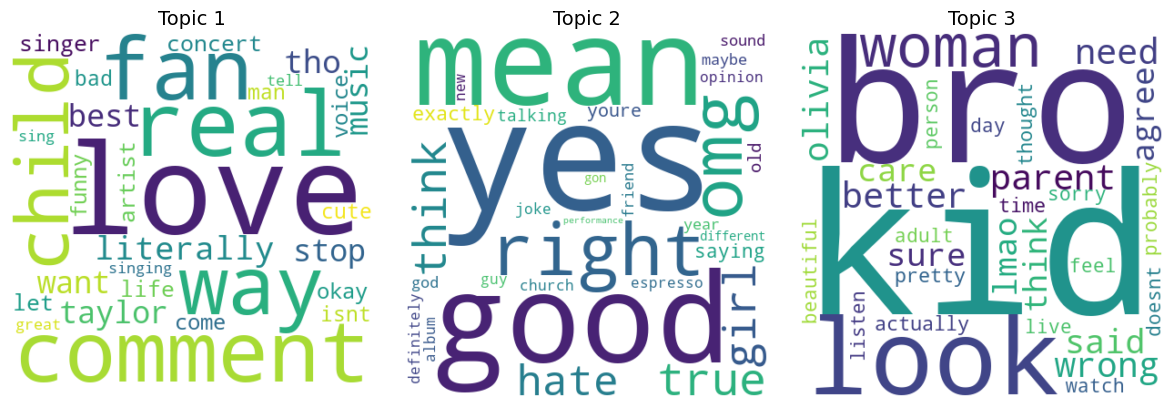

✅ Word clouds saved as 'lda_wordclouds.png'.


In [39]:
# Word Cloud Visualization
print("Generating word clouds...")
fig, axes = plt.subplots(1, best_num_topics, figsize=(4 * best_num_topics, 4))
for i in range(best_num_topics):
    topic_words = dict(final_lda_model.show_topic(i, topn=30))
    wc = WordCloud(width=400, height=400, background_color='white', colormap='viridis').generate_from_frequencies(topic_words)
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].set_title(f"Topic {i + 1}", fontsize=14)
    axes[i].axis('off')

plt.tight_layout()
plt.savefig("lda_wordclouds.png", dpi=300)
plt.show()
print("Word clouds saved as 'lda_wordclouds.png'.")

In [40]:
# Interactive pyLDAvis Visualization
print("Preparing interactive visualization...")
vis = gensimvis.prepare(final_lda_model, corpus, dictionary)
pyLDAvis.save_html(vis, 'lda_visualization.html')
print("Interactive visualization saved to 'lda_visualization.html'.")

🌐 Preparing interactive visualization...
✅ Interactive visualization saved to 'lda_visualization.html'.
